# 1.5b: Density Field Visualization

This notebook visualizes the density field using nearest-neighbor distances as a proxy for local density.

## The Question

We identified a tight cluster of 2,212 tokens separated from 18,161 singletons by a void (1.4g). But is the cluster **the entire overdensity**, or is there residual density structure in the singletons?

Instead of categorical labels (cluster vs. singleton), we can visualize **continuous density** by coloring each token by its distance to its nearest neighbor:

- **Small distance** → many close neighbors → **high density** → hot colors
- **Large distance** → isolated → **low density** → cool colors

This will reveal:
- Whether the cluster is a discrete high-density core
- Whether singletons have uniform low density
- Whether there's intermediate-density structure (gradient vs. binary)

## Method

We'll:
1. Load the distance matrix from 1.4b
2. Compute nearest-neighbor distance for each token
3. Create two visualizations with continuous colormaps:
   - Mollweide projection (latitude vs longitude)
   - Polar projection (radius vs longitude)

## Parameters

In [10]:
# Model to analyze
MODEL_NAME = "Qwen3-4B-Instruct-2507"

# PCA basis (must match 1.3a/1.3b/1.4a)
NORTH_PC = 2
MERIDIAN_PC = 1
EQUINOX_PC = 3

# Visualization
COLORMAP = 'inferno_r'  # Try: 'inferno', 'viridis', 'hot', 'plasma', 'magma'
FIGSIZE = (16, 8)
DPI = 200

# Color scale (optional - set to None for auto)
VMIN = None  # Minimum distance for colormap
VMAX = None  # Maximum distance for colormap

## Imports

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from safetensors.torch import load_file
from pathlib import Path

## Load W and Compute Spherical Coordinates

In [12]:
# Load W
tensor_path = Path(f"../tensors/{MODEL_NAME}/W.safetensors")
W_bf16 = load_file(tensor_path)["W"]
W = W_bf16.to(torch.float32)
N, d = W.shape

print(f"Loaded W: {W.shape}")

Loaded W: torch.Size([151936, 2560])


In [13]:
# PCA
print("Computing PCA...")
W_centered = W - W.mean(dim=0)
cov = (W_centered.T @ W_centered) / N
eigenvalues, eigenvectors = torch.linalg.eigh(cov)
idx = torch.argsort(eigenvalues, descending=True)
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]
print("✓ PCA computed")

Computing PCA...
✓ PCA computed


In [14]:
# Define basis
def get_pc_vector(pcs, index):
    pc_num = abs(index) - 1
    vector = pcs[:, pc_num].clone()
    if index < 0:
        vector = -vector
    return vector

north = get_pc_vector(eigenvectors, NORTH_PC)
meridian = get_pc_vector(eigenvectors, MERIDIAN_PC)
equinox = get_pc_vector(eigenvectors, EQUINOX_PC)

In [15]:
# Spherical coordinates for overdensity tokens only
print("Loading overdensity token IDs...")
overdensity_path = Path(f"../tensors/{MODEL_NAME}/1.4b_overdensity_distances.safetensors")
overdensity_data = load_file(overdensity_path)
overdensity_token_ids = overdensity_data['spike_token_ids']

print(f"Loaded {len(overdensity_token_ids):,} overdensity tokens")
print()

# Get vectors for overdensity tokens
overdensity_vecs = W[overdensity_token_ids]

print("Computing spherical coordinates...")
x = overdensity_vecs @ meridian
y = overdensity_vecs @ equinox
z = overdensity_vecs @ north

r = torch.sqrt(x**2 + y**2 + z**2)
lat_rad = torch.asin(torch.clamp(z / r, -1, 1))
lat_deg = torch.rad2deg(lat_rad)
lon_rad = torch.atan2(y, x)
lon_deg = torch.rad2deg(lon_rad)
print("✓ Spherical coordinates computed")

Loading overdensity token IDs...
Loaded 20,373 overdensity tokens

Computing spherical coordinates...
✓ Spherical coordinates computed


## Compute Nearest Neighbor Distances

In [16]:
print("\nComputing nearest neighbor distances...\n")

# Load distance matrix
dists = overdensity_data['distances']

# Set diagonal to infinity (don't pick self as neighbor)
dists_no_diag = dists.clone()
dists_no_diag.fill_diagonal_(float('inf'))

# Find minimum distance for each token
nearest_neighbor_dists, _ = dists_no_diag.min(dim=1)

print(f"✓ Nearest neighbor distances computed")
print(f"\nDistance statistics:")
print(f"  Min: {nearest_neighbor_dists.min():.6f}")
print(f"  Max: {nearest_neighbor_dists.max():.6f}")
print(f"  Mean: {nearest_neighbor_dists.mean():.6f}")
print(f"  Median: {nearest_neighbor_dists.median():.6f}")
print()
print(f"Tokens with nearest neighbor at distance = 0: {(nearest_neighbor_dists == 0).sum().item():,}")


Computing nearest neighbor distances...

✓ Nearest neighbor distances computed

Distance statistics:
  Min: 0.000000
  Max: 1.486558
  Mean: 0.772959
  Median: 0.918001

Tokens with nearest neighbor at distance = 0: 2,100


## Mollweide Density Map


Creating Mollweide density map...



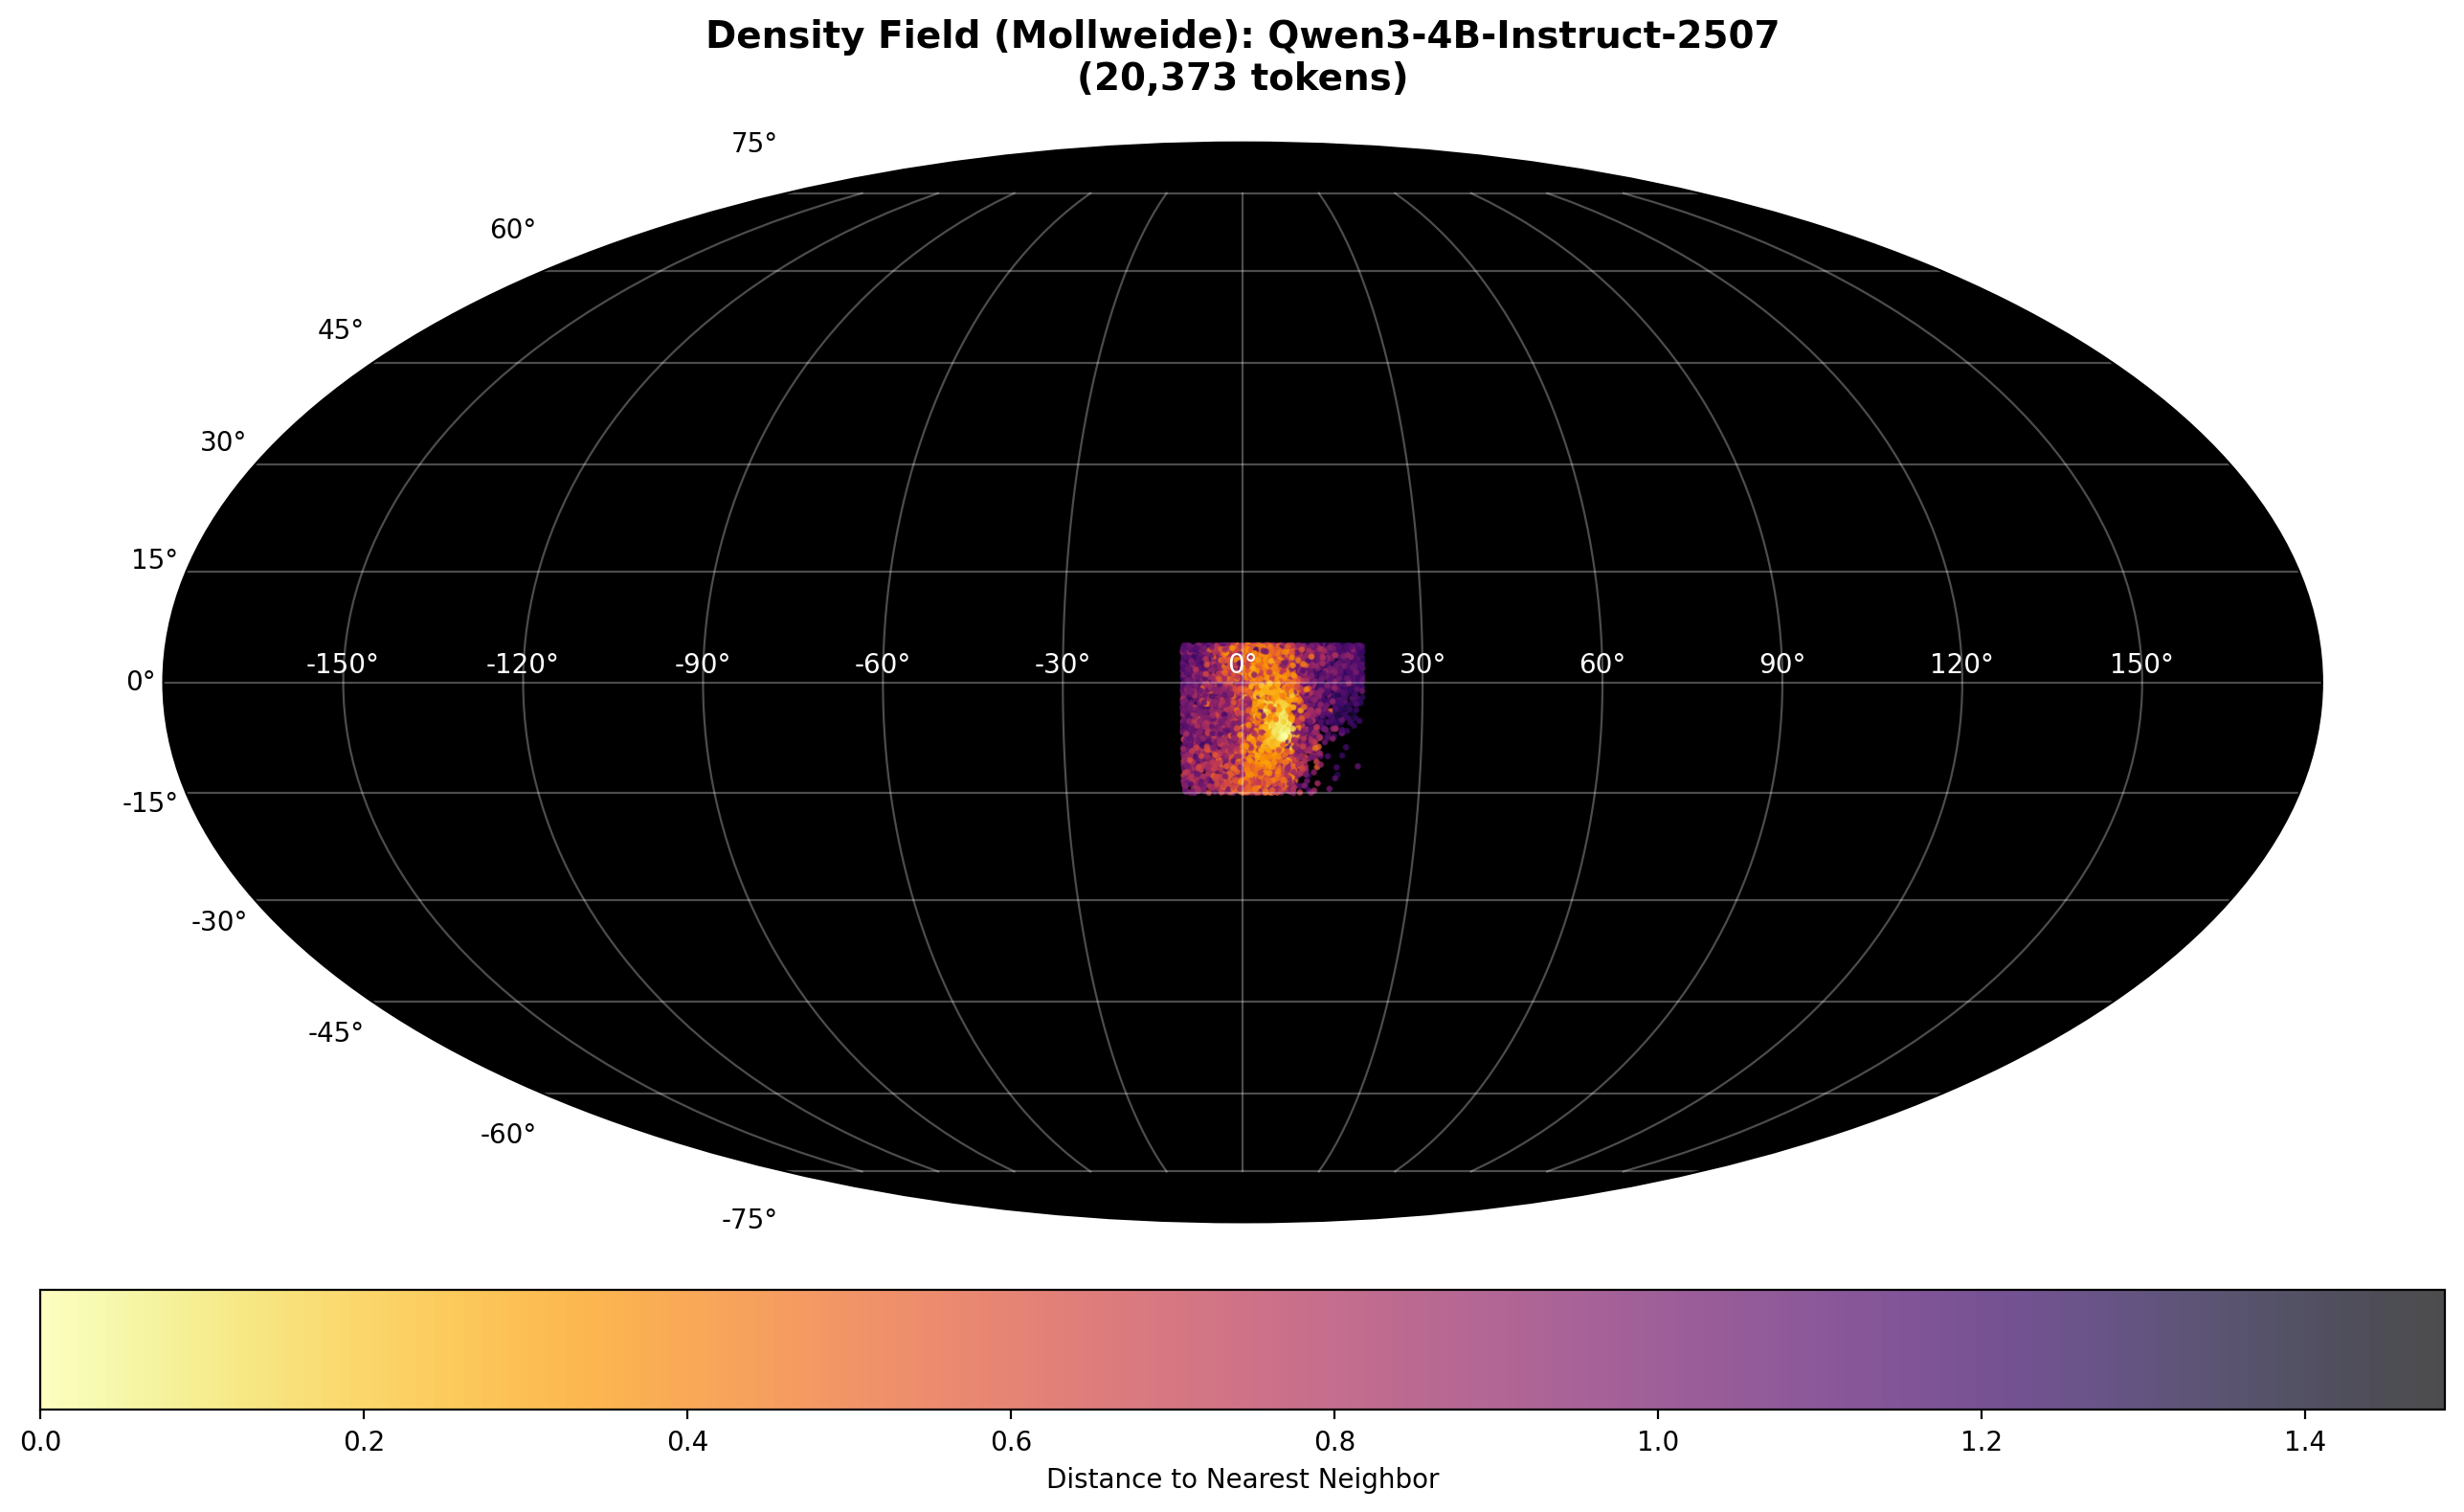

✓ Mollweide density map complete


In [17]:
print(f"\nCreating Mollweide density map...\n")

# Convert to numpy and radians
lon_plot = lon_deg.numpy()
lat_plot = lat_deg.numpy()
lon_rad = np.deg2rad(lon_plot)
lat_rad = np.deg2rad(lat_plot)
nn_dists = nearest_neighbor_dists.numpy()

# Create figure
fig = plt.figure(figsize=FIGSIZE, dpi=DPI)
ax = fig.add_subplot(111, projection='mollweide')
ax.set_facecolor('black')

# Scatter plot with continuous colormap
scatter = ax.scatter(lon_rad, lat_rad, 
                     c=nn_dists, 
                     cmap=COLORMAP,
                     s=2, 
                     alpha=0.7,
                     vmin=VMIN,
                     vmax=VMAX,
                     rasterized=True)

# Colorbar
cbar = plt.colorbar(scatter, ax=ax, orientation='horizontal', pad=0.05, shrink=0.8)
cbar.set_label('Distance to Nearest Neighbor', fontsize=10)

# Formatting
ax.grid(True, alpha=0.3, color='white')
ax.set_title(f'Density Field (Mollweide): {MODEL_NAME}\n({len(overdensity_token_ids):,} tokens)', 
             color='black', pad=20, fontsize=14, fontweight='bold')

# Set tick colors
for label in ax.get_xticklabels():
    label.set_color('white')
for label in ax.get_yticklabels():
    label.set_color('black')

plt.tight_layout()
plt.show()

print("✓ Mollweide density map complete")

## Polar Density Map


Creating polar density map...



/var/folders/k5/44vd1ct56xj4y9h7x213kvjr0000gn/T/ipykernel_46731/37581192.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{int(d)}°' for d in tick_degs])


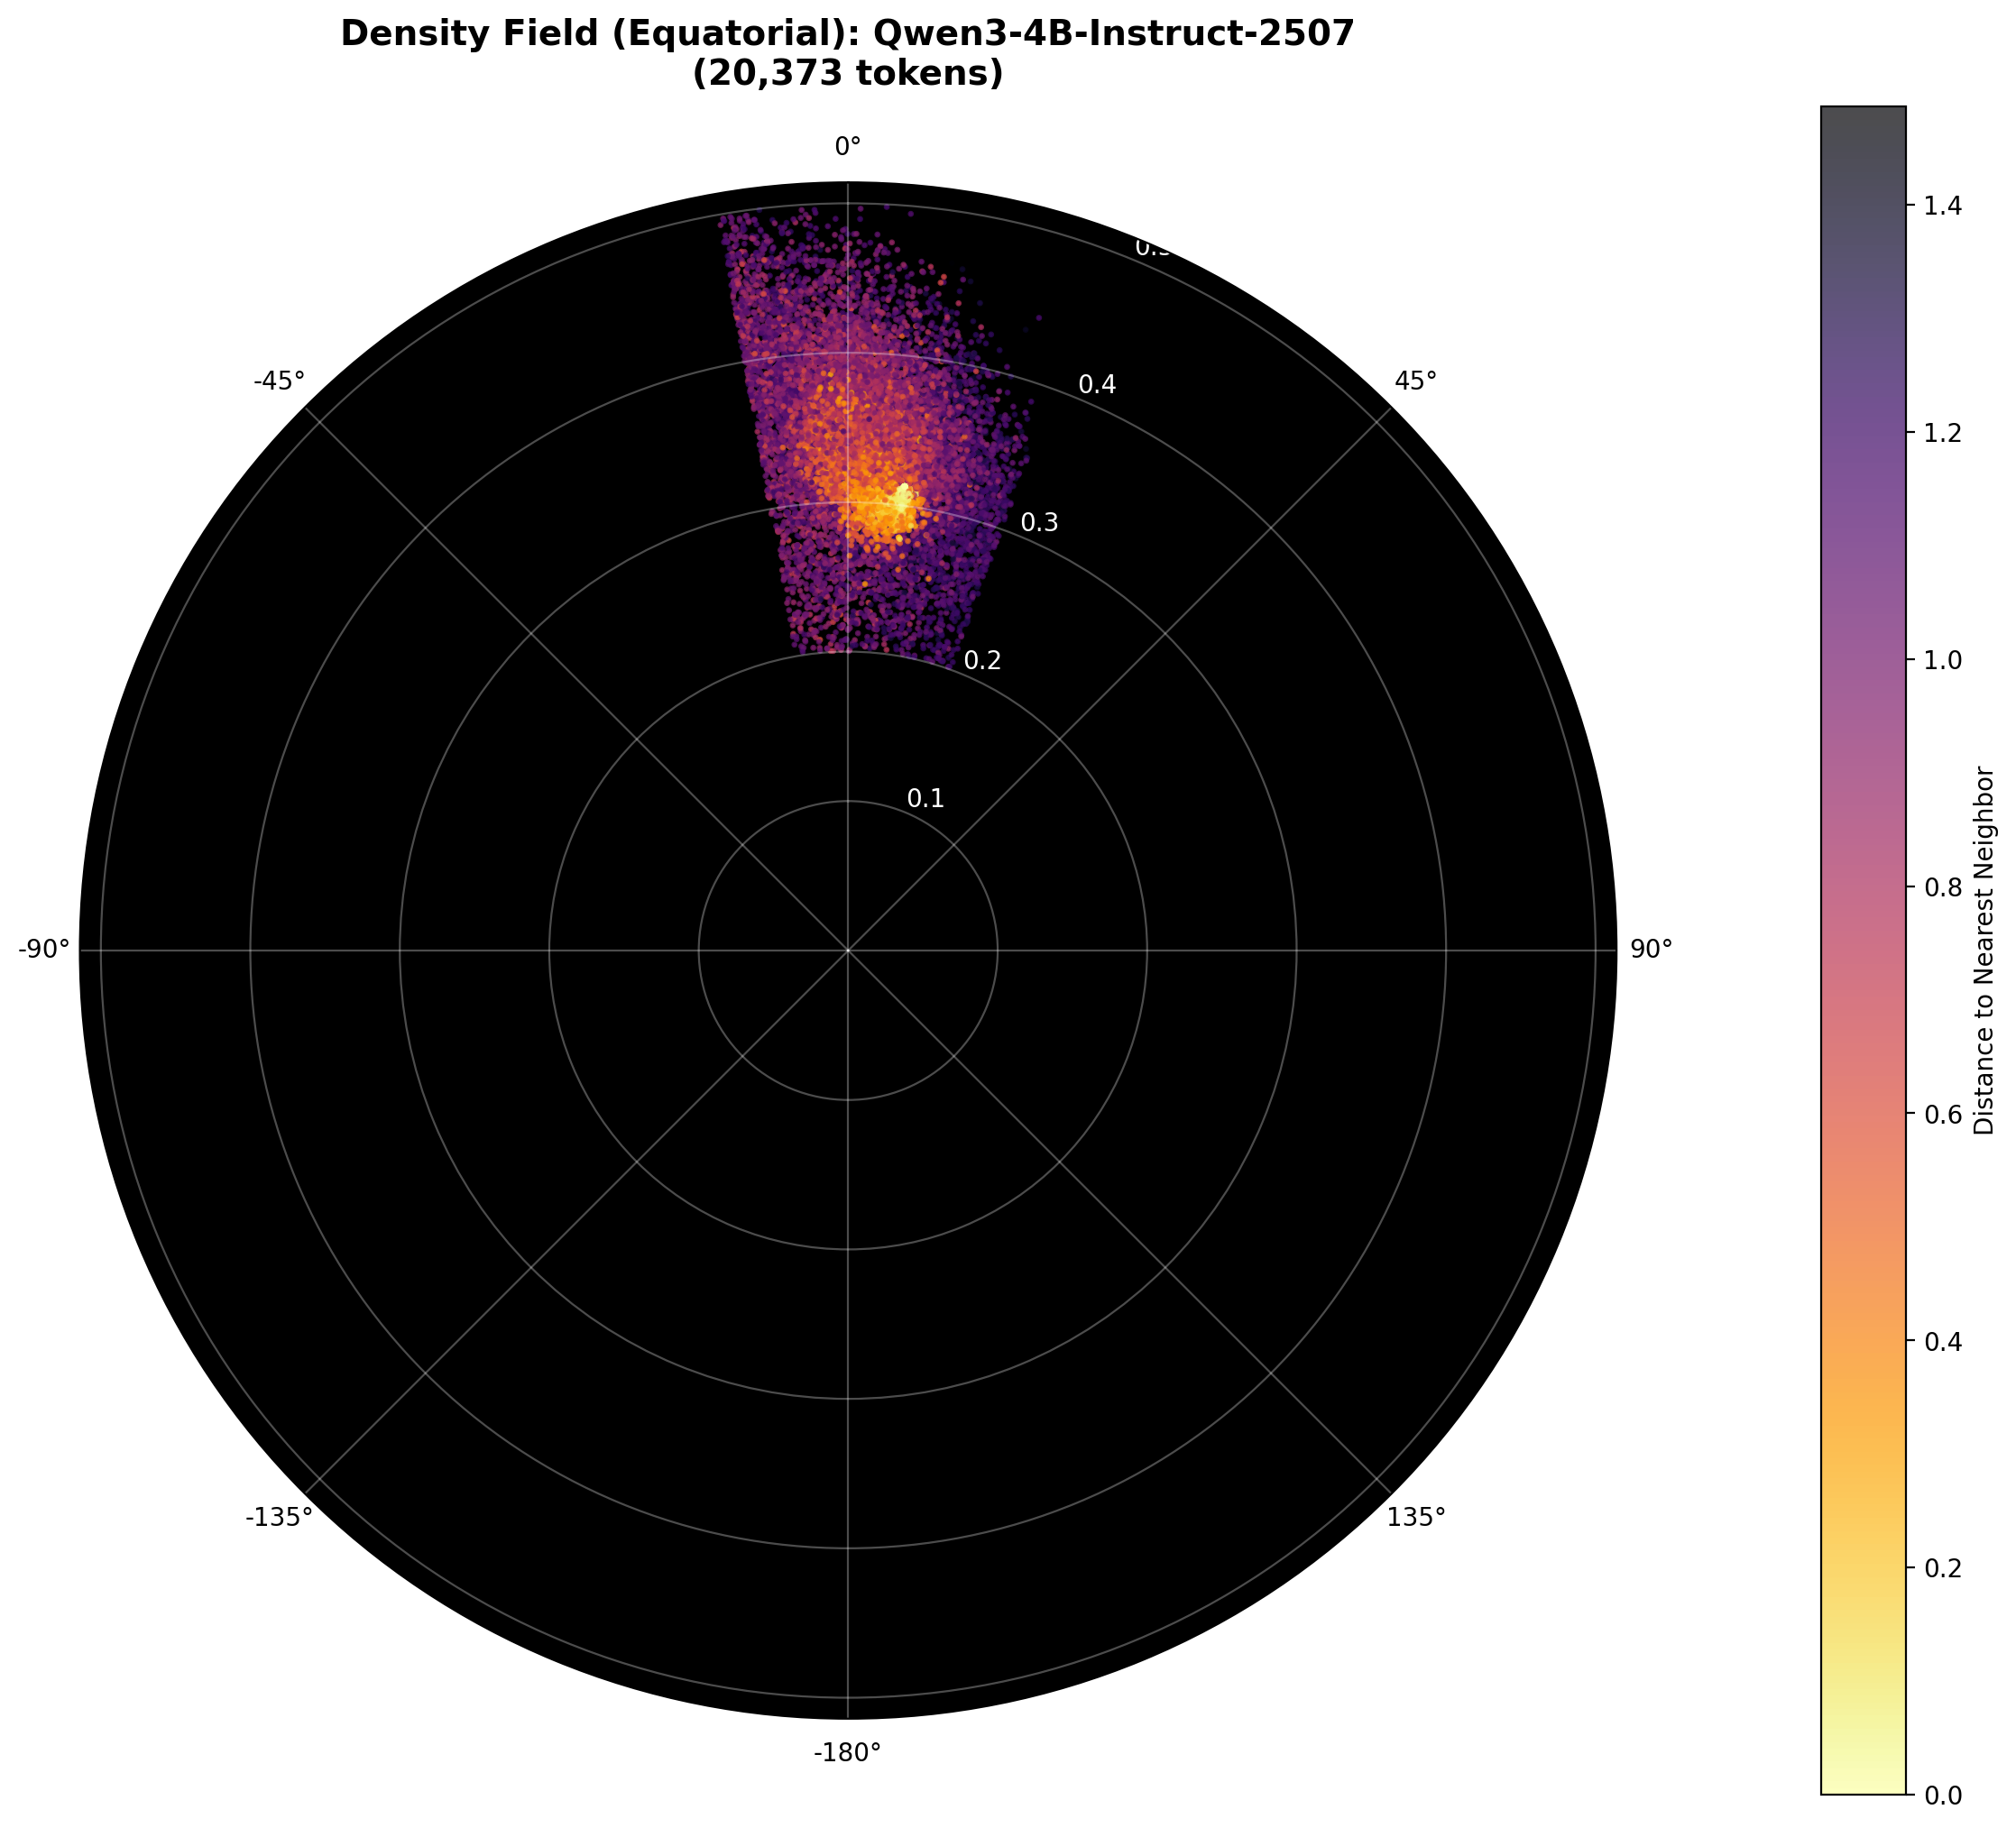

✓ Polar density map complete


In [18]:
print(f"\nCreating polar density map...\n")

# Get radius values
r_plot = r.numpy()

# Create figure
fig = plt.figure(figsize=(12, 12), dpi=DPI)
ax = fig.add_subplot(111, projection='polar')
ax.set_facecolor('black')

# Scatter plot with continuous colormap
scatter = ax.scatter(lon_rad, r_plot, 
                     c=nn_dists, 
                     cmap=COLORMAP,
                     s=2, 
                     alpha=0.7,
                     vmin=VMIN,
                     vmax=VMAX,
                     rasterized=True)

# Colorbar
cbar = plt.colorbar(scatter, ax=ax, pad=0.1, shrink=0.8)
cbar.set_label('Distance to Nearest Neighbor', fontsize=10)

# Formatting
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.grid(True, alpha=0.3, color='white')
ax.set_title(f'Density Field (Equatorial): {MODEL_NAME}\n({len(overdensity_token_ids):,} tokens)', 
             color='black', pad=20, fontsize=14, fontweight='bold')

# Get the default tick positions (in radians)
tick_locs = ax.get_xticks()

# Convert each tick from radians to degrees
tick_degs = np.rad2deg(tick_locs)

# Wrap to -180 to 180 range
tick_degs = ((tick_degs + 180) % 360) - 180

# Set the labels (but keep original positions)
ax.set_xticklabels([f'{int(d)}°' for d in tick_degs])

# Set tick colors
for label in ax.get_xticklabels():
    label.set_color('black')
for label in ax.get_yticklabels():
    label.set_color('white')

plt.tight_layout()
plt.show()

print("✓ Polar density map complete")

## Observations

Look for:

**Density structure:**
- Is there a concentrated hot core (small nearest-neighbor distances)?
- Is there a visible void (dark ring) around the core?
- Are the ambient tokens uniformly cool (large distances)?

**Gradient vs. binary:**
- Does density drop smoothly (gradient from hot to cool)?
- Or is it binary (hot core, cold everything else, no intermediate)?

**Residual structure:**
- Are there warm patches outside the core (intermediate density)?
- Or is everything outside the core uniformly cold?

If the visualization shows a sharp binary structure (hot cluster, dark void, cold ambient), then the 2,212-token cluster **is** the overdensity—the remaining tokens are just normal vocabulary passing through the spatial region.

If there are intermediate densities, there's additional structure beyond the tight cluster.